In [3]:
from battery.battery import Battery
from price_modelling.price_path_generator import IDPriceSimulator
from price_modelling.global_keys import *
from optimization.rolling_intrinsic import RollingIntrinsicStrategy
from optimization.LSM import LSMStrategy
import pandas as pd
import yaml
import numpy as np

Tune ID price simulator to ID VWAP and DA auction data

In [5]:
df_all_VWAP_data_DA = pd.read_csv("../data/all_VWAP_DA_data_spring.csv", sep=";")
# set columns to datetime type
df_all_VWAP_data_DA["delivery_start"] = pd.to_datetime(df_all_VWAP_data_DA["delivery_start"])
df_all_VWAP_data_DA["delivery_start_hour"] = pd.to_datetime(df_all_VWAP_data_DA["delivery_start_hour"])
df_all_VWAP_data_DA["traded"] = pd.to_datetime(df_all_VWAP_data_DA["traded"])
df_all_VWAP_data_DA = df_all_VWAP_data_DA.loc[np.abs(df_all_VWAP_data_DA["delta_VWAP_DA"]) < 300]

price_generator_DA = IDPriceSimulator(config)
price_generator_DA.fit_model(df_all_VWAP_data_DA)

In [3]:
price_generator_DA.param_plot("spring")

/Users/rickvanvoorbergen/Mijn Drive/Studie/Masters/Thesis/battery_intraday_trading/src/price_modelling/price_path_generator.py:191: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



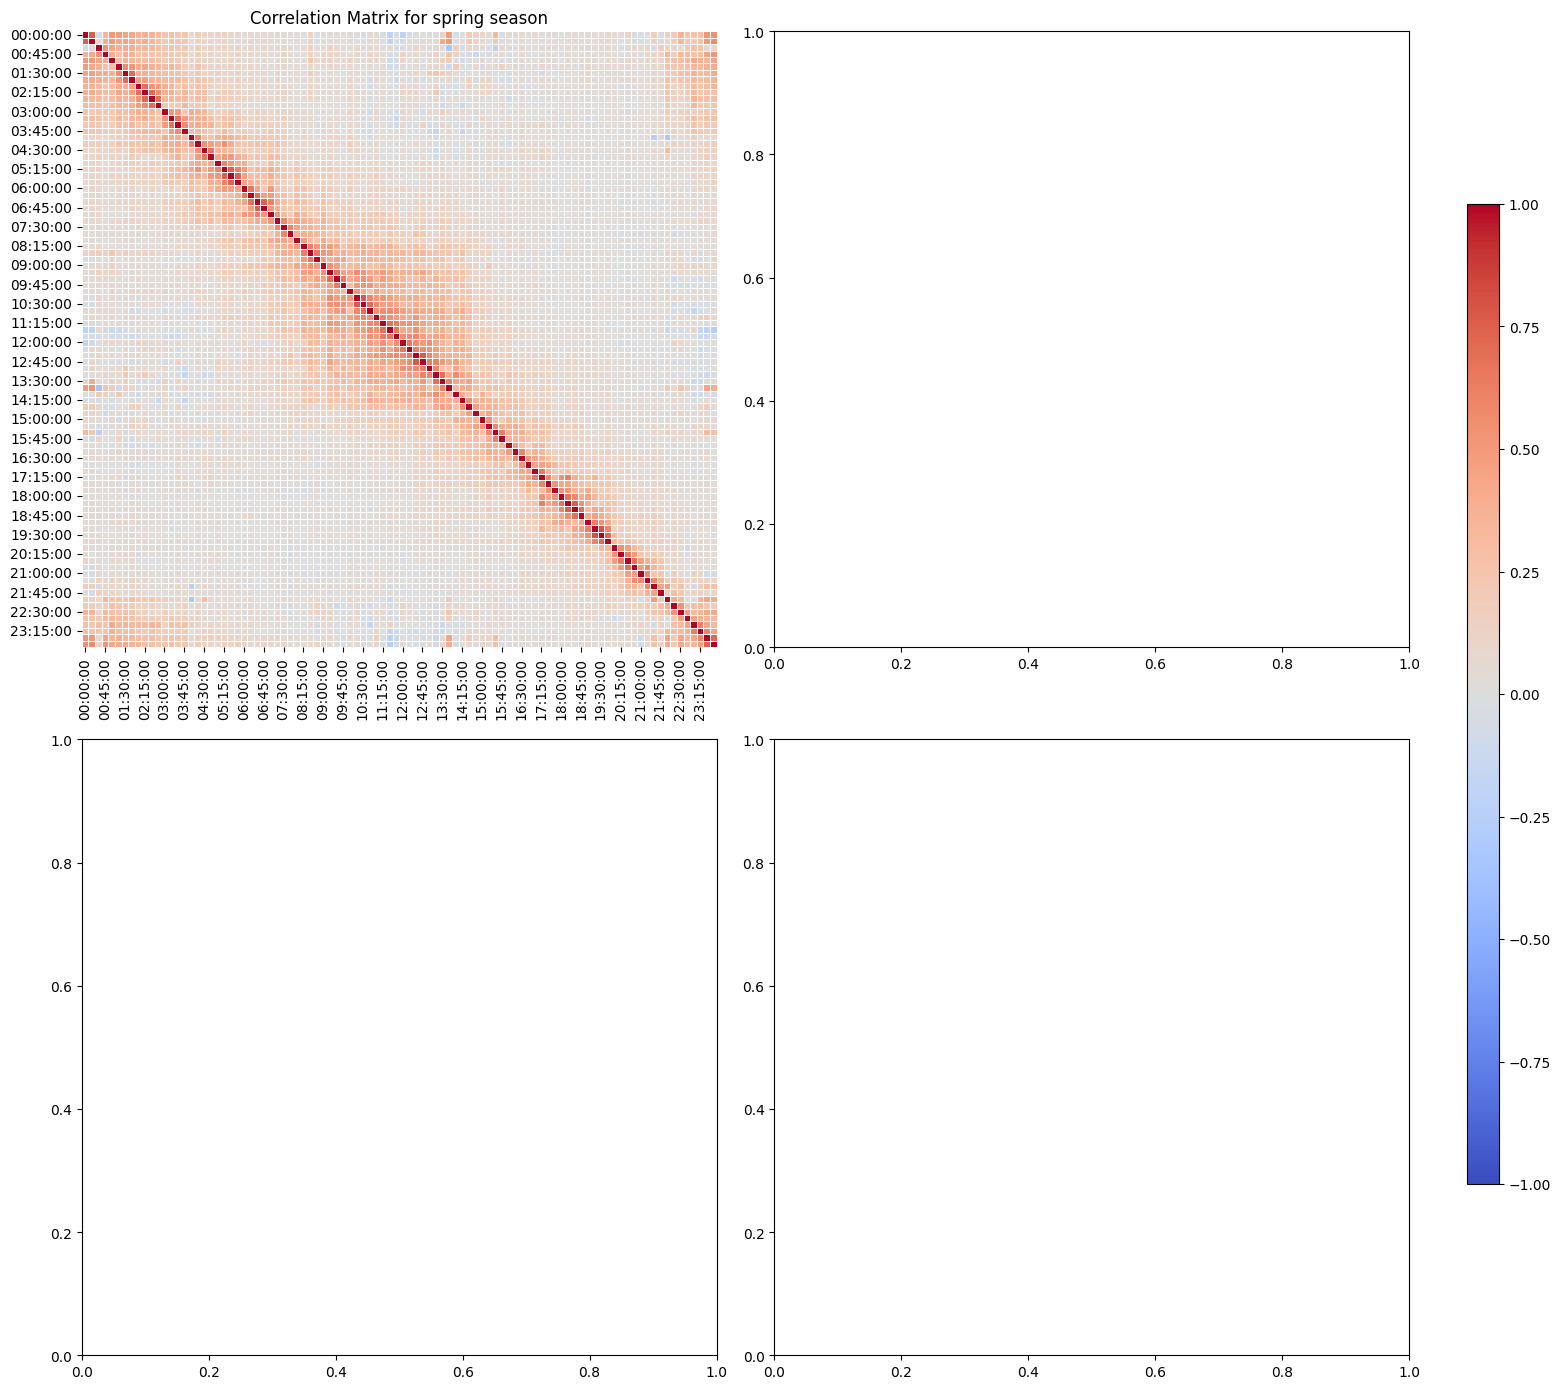

In [4]:
price_generator_DA.cor_heatmaps()

Setup Battery

In [6]:
# read config.yml
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)  

battery = Battery(config)

Create test price path array

In [7]:
price_path_array, P = price_generator_DA.generate_price_paths(season="spring", N_paths=1)
price_path = price_path_array[0, :, :]

TypeError: IDPriceSimulator.generate_price_paths() missing 1 required positional argument: 'df_DA_prices'

In [6]:
price_path_array = np.ones((1,config["N_trading_timesteps"],config["N_timesteps"]))

price_path_array[0,0,1:4] = 5
price_path_array[0,0,26:29] = 0

price_path_array[0,1,4:7] = -10
price_path_array[0,1,23:26] = 2

price_path_array[0,4,10:15] = -30
# price_path_array[0,4,26:29] = 0

# price_path_array[0,4,4:7] = -10
# price_path_array[0,4,23:26] = 2





In [20]:
import plotly.graph_objects as go

# Plot all price paths in price_path_array
fig = go.Figure()
n_trading_timesteps = price_path_array.shape[1]
n_timesteps = price_path_array.shape[2]

for i in range(5):
    # Add a label for every path, named "Path i"
    fig.add_trace(
        go.Scatter(
            y=price_path_array[0, i, :],  # Plot the first trading timestep for the label
            mode="lines",
            name=f"Path {i}",
            showlegend=True,
            line=dict(width=2, dash="solid")
        )
    )

fig.update_layout(
    title="Price Paths",
    xaxis_title="Timestep",
    yaxis_title="Price",
    showlegend=True,  # Always show legend
    height=400,
    width=800
)
fig.show()



In [21]:
price_path = price_path_array[0,:,:]
intrinsic_strategy = RollingIntrinsicStrategy(battery, price_path, config)

In [22]:
power_schedules , power_incremental_schedules, soc_schedules, price_path, results = intrinsic_strategy.run()

In [23]:
eps = 1e-8

# Test if schedules are within bounds
for power_schedule in power_schedules:
    assert np.all(np.abs(power_schedule) <= battery.capacity)

for soc_schedule in soc_schedules:
    assert np.all(soc_schedule >= -eps) and np.all(soc_schedule <= 1+eps)

# Test if results are equal to power_schedule multiplied by price_path
for t in range(2, len(results) - 1):
    # print(t)
    assert np.abs(results[t]-results[t-1] - np.sum((power_schedules[t] - power_schedules[t-1]) * price_path[t,:])) < eps

# Test if commited power schedules are within bounds
for t in range(2, len(results) - 1):
    assert np.all(np.abs(power_schedules[t]) <= battery.capacity + eps)

    


# Test if the number of cycles is less than the maximum allowed
# assert np.sum(np.abs(power_schedules[-1]))/2 * battery.RTE <= battery.N_daily_cycles_max
# # Lower bound on revenues
# costs = np.sum(power_schedules * price_path[0,:,:], axis=1)
# # assert np.all(costs >= 0)
# costs

In [24]:

# plot schedule for timesteps 0 to 4
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define color palettes for different timesteps
soc_colors = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]  # blue, green, red, purple, brown
price_colors = ["#ff7f0e", "#17becf", "#e377c2", "#bcbd22", "#7f7f7f"]  # orange, cyan, pink, olive, gray

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

for timestep in range(5):  # Show timesteps 0 to 4
    # Add SOC schedule trace on primary y-axis
    fig.add_trace(
        go.Scatter(
            x=list(range(len(soc_schedules[timestep]))),
            y=soc_schedules[timestep],
            name=f"SOC (t={timestep})",
            line=dict(color=soc_colors[timestep % len(soc_colors)]),
            mode="lines",
            # line_shape="hv"
            showlegend=True
        ),
        secondary_y=False
    )

    # # Add power incremental path trace on secondary y-axis
    # fig.add_trace(
    #     go.Scatter(
    #         x=list(range(len(power_incremental_schedules[timestep]))),
    #         y=power_incremental_schedules[timestep],
    #         name=f"Power Incremental (t={timestep})",
    #         line=dict(color=price_colors[timestep % len(price_colors)], dash="dot"),
    #         mode="lines",
    #         line_shape="hv",
    #         showlegend=True
    #     ),
    #     secondary_y=True
    # )

    # # Add price path trace on secondary y-axis
    fig.add_trace(
        go.Scatter(
            x=list(range(len(price_path[timestep, :]))),
            y=price_path[timestep, :],
            name=f"Price (t={timestep})",
            line=dict(color=price_colors[timestep % len(price_colors)], dash="dot"),
            mode="lines",
            line_shape="hv",
            showlegend=True
        ),
        secondary_y=True
    )

# Set titles and labels with white background and dark text
fig.update_layout(
    title_text="Battery State of Charge and Price Path (Timesteps 0-4)",
    hovermode="x unified",
    template="plotly_white",  # Use white template
    paper_bgcolor="white",  # White background color
    plot_bgcolor="white",
    font=dict(color="black")  # Black text
)
fig.update_xaxes(title_text="Time Step", gridcolor="rgba(0, 0, 0, 0.1)")
fig.update_yaxes(title_text="State of Charge (SOC)", secondary_y=False, gridcolor="rgba(0, 0, 0, 0.1)")
fig.update_yaxes(title_text="Price", secondary_y=True, gridcolor="rgba(0, 0, 0, 0.1)")

# Show the interactive plot
fig.show()

In [26]:

fig = make_subplots()

# Add SOC schedule trace on primary y-axis
fig.add_trace(
    go.Scatter(
        x=list(range(len(results))),
        y=results,
        name="Revenues [€]",
        line=dict(color="#00BFFF"),  # Bright blue for better visibility on dark theme
        mode="lines",
        line_shape="hv"
    )
)


# Set titles and labels with dark theme
fig.update_layout(
    title_text="Battery State of Charge and Price Path",
    hovermode="x unified",
    template="plotly_dark",  # Use dark template
    paper_bgcolor="rgb(30, 30, 30)",  # Dark background color
    plot_bgcolor="rgb(30, 30, 30)",
    font=dict(color="white")  # White text
)
fig.update_xaxes(title_text="Time Step", gridcolor="rgba(255, 255, 255, 0.2)")
fig.update_yaxes(title_text="Revenues [€]", secondary_y=False, gridcolor="rgba(255, 255, 255, 0.2)")

# Show the interactive plot
fig.show()

In [4]:
LSM_strategy = LSMStrategy(battery, price_generator_DA, config)

In [6]:
LSM_strategy.run()

IndexError: index 0 is out of bounds for axis 0 with size 0